## Cell 1: Setup and Imports

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, differential_evolution, basinhopping, shgo
import json
import time




## Cell 2: Load Data and Define $t$

In [22]:
# Load the dataset
try:
    df = pd.read_csv('xy_data.csv')
    x_data = df['x'].values
    y_data = df['y'].values
    num_points = len(df)
    
    print(f"Loaded {num_points} data points.")
    
    # Create the assumed 't' values
    # We assume the points in the CSV file correspond to a linear spacing of 't'
    t_values = np.linspace(6.0, 60.0, num_points)
    
    print("t_values generated ranging from 6.0 to 60.0.")
    
except FileNotFoundError:
    print("Error: xy_data.csv not found.")
    print("Please make sure the file is in the same directory.")
    # You might want to stop execution here if the file isn't found
    # For a notebook, we'll let it continue but subsequent cells will fail
    x_data, y_data, t_values = None, None, None

Loaded 1500 data points.
t_values generated ranging from 6.0 to 60.0.


## Cell 3: Define Model and Objective Function

In [23]:
# Define the parametric equations
def x_model(t, theta_rad, M, X):
    """Calculates the x-coordinate of the parametric equation."""
    term1 = t * np.cos(theta_rad)
    term2 = np.exp(M * np.abs(t)) * np.sin(0.3 * t) * np.sin(theta_rad)
    return term1 - term2 + X

def y_model(t, theta_rad, M, X):
    """Calculates the y-coordinate of the parametric equation."""
    term1 = t * np.sin(theta_rad)
    term2 = np.exp(M * np.abs(t)) * np.sin(0.3 * t) * np.cos(theta_rad)
    return 42.0 + term1 + term2

# Define the objective function (L1 Loss)
def objective_L1(params):
    """
    Calculates the L1 loss for a given set of parameters.
    'params' is an array-like [theta_degrees, M, X]
    """
    theta_deg, M, X = params
    
    # Convert theta from degrees to radians for trigonometric functions
    theta_rad = np.deg2rad(theta_deg)
    
    # Calculate predicted values
    x_pred = x_model(t_values, theta_rad, M, X)
    y_pred = y_model(t_values, theta_rad, M, X)
    
    # Calculate L1 error (Manhattan distance)
    # This is the sum of absolute differences for both x and y
    error = np.sum(np.abs(x_data - x_pred) + np.abs(y_data - y_pred))
    
    return error

# Define parameter bounds and initial guess
# [theta_degrees, M, X]
param_bounds = [(0.0, 50.0), (-0.05, 0.05), (0.0, 100.0)]
initial_guess = [25.0, 0.0, 50.0]

print("Model and objective function (L1 Loss) defined.")

Model and objective function (L1 Loss) defined.


## Cell 4: Run Optimization Approaches

In [24]:
results_dict = {}
all_params = {}

print("Starting optimization... This may take a few minutes.")

# --- Approach 1: L-BFGS-B (Local Optimizer) ---
print("Running Approach 1: L-BFGS-B...")
start_time = time.time()
res_lbfgsb = minimize(objective_L1, 
                        initial_guess, 
                        method='L-BFGS-B', 
                        bounds=param_bounds)
end_time = time.time()
results_dict['L-BFGS-B'] = {
    'l1_error': res_lbfgsb.fun,
    'params': res_lbfgsb.x.tolist(),
    'time_sec': end_time - start_time,
    'success': bool(res_lbfgsb.success)
}
all_params['L-BFGS-B'] = res_lbfgsb.x
print(f"L-BFGS-B complete. Error: {res_lbfgsb.fun:.4f}\n")


# --- Approach 2: SLSQP (Local Optimizer) ---
print("Running Approach 2: SLSQP...")
start_time = time.time()
res_slsqp = minimize(objective_L1, 
                       initial_guess, 
                       method='SLSQP', 
                       bounds=param_bounds)
end_time = time.time()
results_dict['SLSQP'] = {
    'l1_error': res_slsqp.fun,
    'params': res_slsqp.x.tolist(),
    'time_sec': end_time - start_time,
    'success': bool(res_slsqp.success)
}
all_params['SLSQP'] = res_slsqp.x
print(f"SLSQP complete. Error: {res_slsqp.fun:.4f}\n")


# --- Approach 3: Basin-Hopping (Global/Local Hybrid) ---
print("Running Approach 3: Basin-Hopping...")
# Basin-hopping uses a local minimizer (L-BFGS-B) and "hops" to find new basins
minimizer_kwargs = {'method': 'L-BFGS-B', 'bounds': param_bounds}
start_time = time.time()
# niter=50 is a balance between speed and thoroughness. Increase for better (slower) results.
res_basin = basinhopping(objective_L1, 
                           initial_guess, 
                           minimizer_kwargs=minimizer_kwargs, 
                           niter=50,
                           seed=42)
end_time = time.time()
results_dict['Basin-Hopping'] = {
    'l1_error': res_basin.fun,
    'params': res_basin.x.tolist(),
    'time_sec': end_time - start_time,
    'success': True # basinhopping doesn't have a simple 'success' flag
}
all_params['Basin-Hopping'] = res_basin.x
print(f"Basin-Hopping complete. Error: {res_basin.fun:.4f}\n")


# --- Approach 4: SHGO (Global Optimizer) ---
print("Running Approach 4: SHGO...")
start_time = time.time()
res_shgo = shgo(objective_L1, 
                  bounds=param_bounds, 
                  n=100, iters=5, # Parameters to balance speed and accuracy
                  sampling_method='sobol')
end_time = time.time()
results_dict['SHGO'] = {
    'l1_error': res_shgo.fun,
    'params': res_shgo.x.tolist(),
    'time_sec': end_time - start_time,
    'success': bool(res_shgo.success)
}
all_params['SHGO'] = res_shgo.x
print(f"SHGO complete. Error: {res_shgo.fun:.4f}\n")


# --- Approach 5: Differential Evolution (Global Optimizer) ---
print("Running Approach 5: Differential Evolution...")
start_time = time.time()
res_de = differential_evolution(objective_L1, 
                                  bounds=param_bounds, 
                                  seed=42, 
                                  maxiter=500) # Increase maxiter for better (slower) results
end_time = time.time()
results_dict['Differential Evolution'] = {
    'l1_error': res_de.fun,
    'params': res_de.x.tolist(),
    'time_sec': end_time - start_time,
    'success': bool(res_de.success)
}
all_params['Differential Evolution'] = res_de.x
print(f"Differential Evolution complete. Error: {res_de.fun:.4f}\n")

print("All optimizations finished.")

Starting optimization... This may take a few minutes.
Running Approach 1: L-BFGS-B...
L-BFGS-B complete. Error: 37865.0939

Running Approach 2: SLSQP...
SLSQP complete. Error: 37865.0938

Running Approach 3: Basin-Hopping...
Basin-Hopping complete. Error: 37865.0939

Running Approach 4: SHGO...


c:\Users\kotav\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


SHGO complete. Error: 37865.0938

Running Approach 5: Differential Evolution...
Differential Evolution complete. Error: 37865.1076

All optimizations finished.


## Cell 5: Analyze Results and Save to JSON

In [25]:
# Find the best approach
best_approach = min(results_dict, key=lambda k: results_dict[k]['l1_error'])
best_params_list = results_dict[best_approach]['params']
best_error = results_dict[best_approach]['l1_error']

theta_best_deg, M_best, X_best = best_params_list

print("--- Optimization Results ---")
print(f"Best Approach: {best_approach}")
print(f"  Minimum L1 Error: {best_error:,.4f}")
print(f"  Best Parameters:")
print(f"    theta (degrees) = {theta_best_deg:.6f}")
print(f"    M               = {M_best:.6f}")
print(f"    X               = {X_best:.6f}")
print("\n--- All Results ---")
print(json.dumps(results_dict, indent=2))

# Save results to a JSON file
json_filename = 'optimization_results.json'
with open(json_filename, 'w') as f:
    json.dump(results_dict, f, indent=4)
    
print(f"\nAll results saved to {json_filename}")

--- Optimization Results ---
Best Approach: SHGO
  Minimum L1 Error: 37,865.0938
  Best Parameters:
    theta (degrees) = 28.118423
    M               = 0.021389
    X               = 54.900299

--- All Results ---
{
  "L-BFGS-B": {
    "l1_error": 37865.09390023752,
    "params": [
      28.11836711620858,
      0.02138864793326844,
      54.90210910908283
    ],
    "time_sec": 0.06104636192321777,
    "success": true
  },
  "SLSQP": {
    "l1_error": 37865.093840145266,
    "params": [
      28.11842418077076,
      0.02138894705624849,
      54.899937048247054
    ],
    "time_sec": 0.016023874282836914,
    "success": true
  },
  "Basin-Hopping": {
    "l1_error": 37865.093860107474,
    "params": [
      28.11840424949173,
      0.021388846953583743,
      54.89854621570669
    ],
    "time_sec": 0.7163114547729492,
    "success": true
  },
  "SHGO": {
    "l1_error": 37865.093837615714,
    "params": [
      28.11842301489249,
      0.02138895693287436,
      54.90029883686522


## Cell 6: Plot 1 - Best Fit Curve vs. Original Data

Plot saved as best_fit_vs_data.png


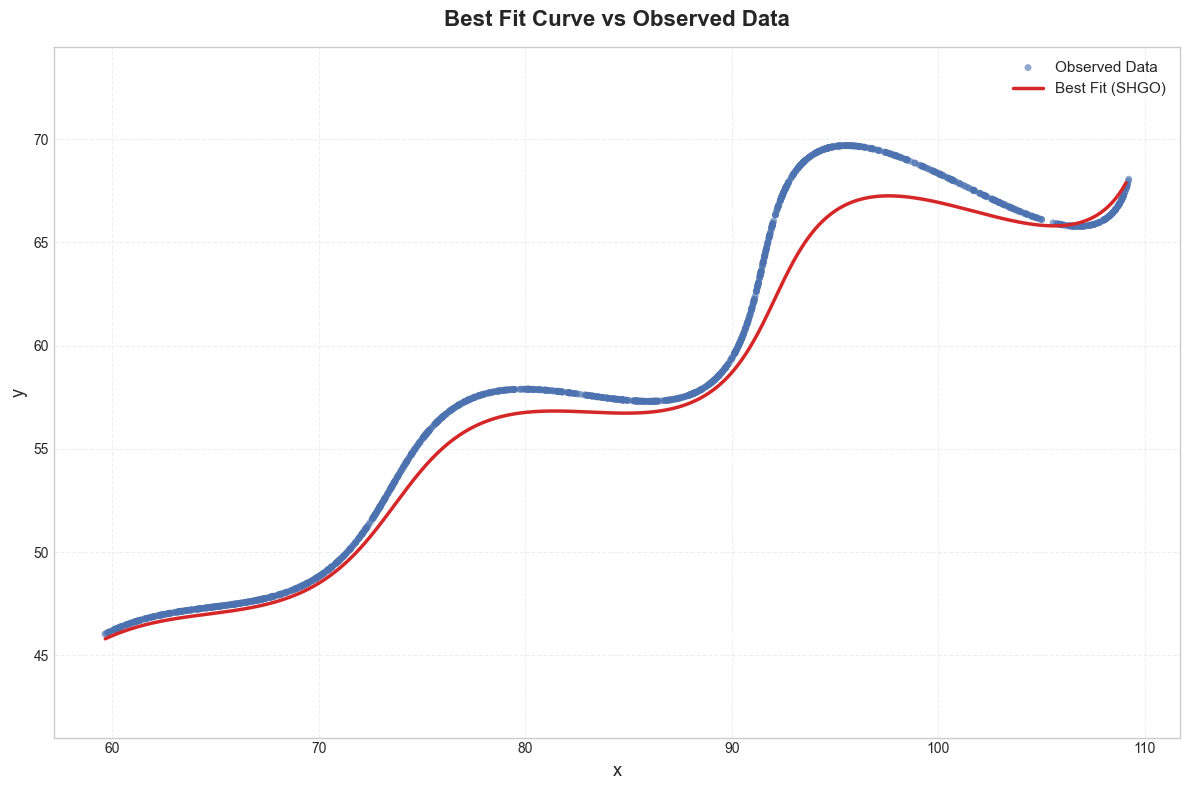

In [26]:
# Generate x and y values for all 5 curves
plot_curves = {}
for name, params in all_params.items():
    theta_rad = np.deg2rad(params[0])
    M = params[1]
    X = params[2]
    x_curve = x_model(t_values, theta_rad, M, X)
    y_curve = y_model(t_values, theta_rad, M, X)
    plot_curves[name] = (x_curve, y_curve)

# --- Plot: Best Fit vs Data ---
plt.figure(figsize=(12, 8))

# Original data points
plt.scatter(
    x_data, y_data, 
    label='Observed Data', 
    color='#4C72B0', alpha=0.6, s=25, edgecolor='none'
)

# Best fit curve
best_x, best_y = plot_curves[best_approach]
plt.plot(
    best_x, best_y, 
    color='#D62728', linewidth=2.5, linestyle='-', 
    label=f'Best Fit ({best_approach})'
)

# Labels and title
plt.title('Best Fit Curve vs Observed Data', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('x', fontsize=13)
plt.ylabel('y', fontsize=13)

# Aesthetics
plt.legend(fontsize=11, frameon=False)
plt.grid(True, linestyle='--', alpha=0.3)
plt.axis('equal')
plt.tight_layout()

# Save plot
plot_filename_1 = 'best_fit_vs_data.png'
plt.savefig(plot_filename_1, dpi=300, bbox_inches='tight')
print(f"Plot saved as {plot_filename_1}")
# plt.show()


## Cell 7: Plot 2 - All Approaches vs. Original Data

Plot 2 saved as all_approaches_vs_data.png


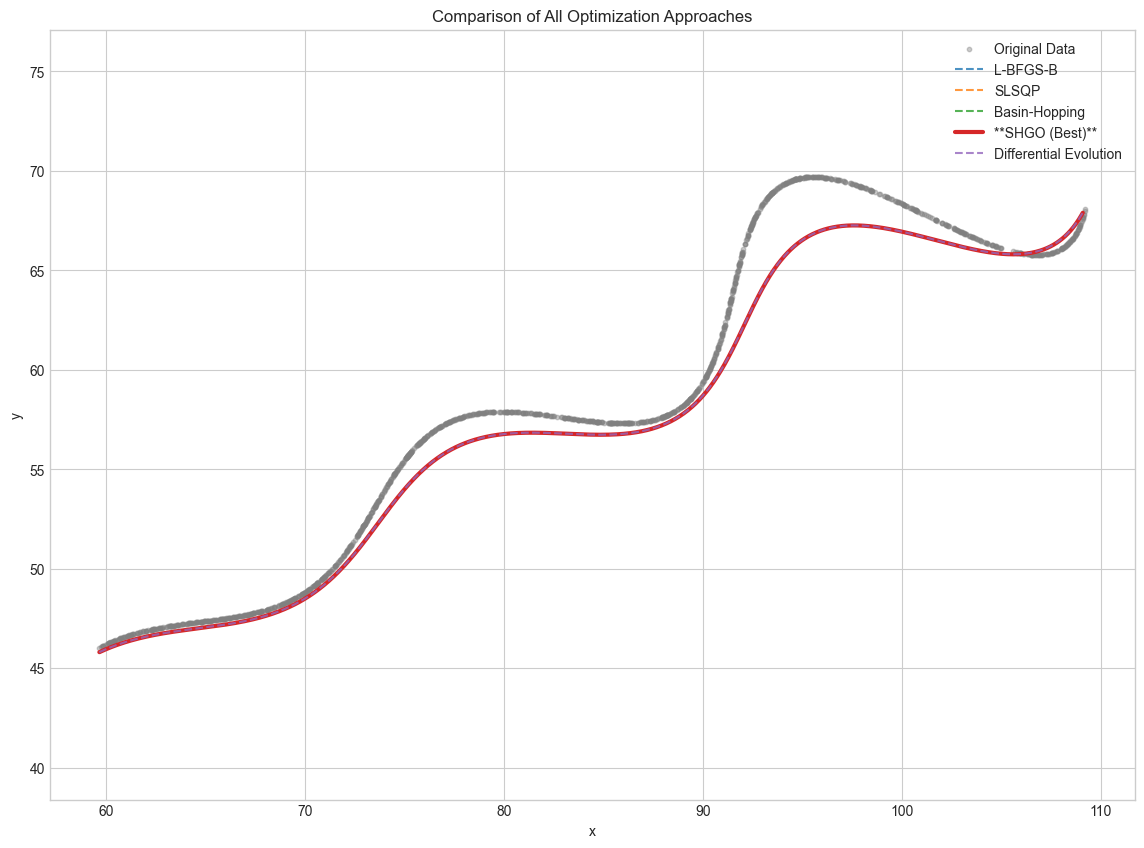

In [27]:
# Plot 2: All Approaches vs. Data
plt.figure(figsize=(14, 10))
# Plot the original data points
plt.scatter(x_data, y_data, label='Original Data', alpha=0.4, s=10, color='gray')

# Plot all 5 curves
for name, (x_curve, y_curve) in plot_curves.items():
    if name == best_approach:
        # Plot best one thicker and more prominently
        plt.plot(x_curve, y_curve, linewidth=3, 
                 label=f'**{name} (Best)**')
    else:
        plt.plot(x_curve, y_curve, linewidth=1.5, linestyle='--', 
                 alpha=0.8, label=f'{name}')

plt.title('Comparison of All Optimization Approaches')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
plt.grid(True)
plt.axis('equal')

# Save the plot
plot_filename_2 = 'all_approaches_vs_data.png'
plt.savefig(plot_filename_2, dpi=300, bbox_inches='tight')
print(f"Plot 2 saved as {plot_filename_2}")
# plt.show()

## Cell 8: Plot 3 - Bar Chart of Results

Plot 3 saved as results_bar_chart.png


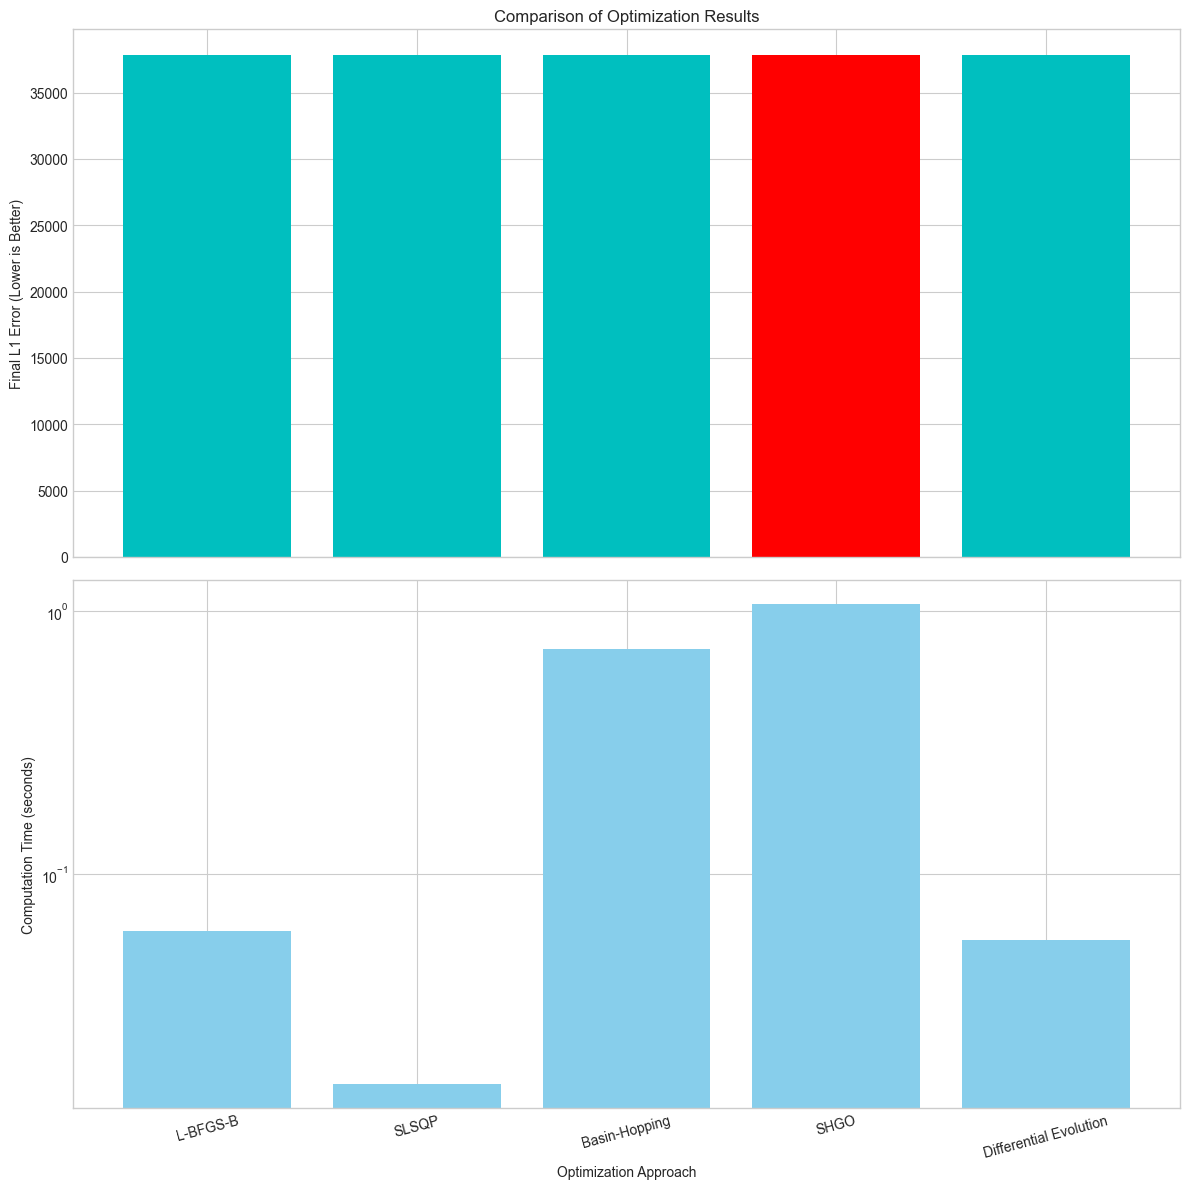

In [28]:
# Plot 3: Bar chart of L1 Errors and Times
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

# Plot 1: L1 Error
approaches = list(results_dict.keys())
errors = [results_dict[k]['l1_error'] for k in approaches]
colors = ['r' if k == best_approach else 'c' for k in approaches]

ax1.bar(approaches, errors, color=colors)
ax1.set_ylabel('Final L1 Error (Lower is Better)')
ax1.set_title('Comparison of Optimization Results')
# Use scientific notation if errors are large, or log scale if they vary widely
# ax1.set_yscale('log') # Uncomment if errors are very different

# Plot 2: Computation Time
times = [results_dict[k]['time_sec'] for k in approaches]
ax2.bar(approaches, times, color='skyblue')
ax2.set_ylabel('Computation Time (seconds)')
ax2.set_xlabel('Optimization Approach')
ax2.set_yscale('log') # Times often vary a lot, log scale is useful

plt.xticks(rotation=15)
plt.tight_layout()

# Save the plot
plot_filename_3 = 'results_bar_chart.png'
plt.savefig(plot_filename_3, dpi=300, bbox_inches='tight')
print(f"Plot 3 saved as {plot_filename_3}")
# plt.show()

## Cell 9: Final LaTeX Output

In [29]:
# Get the best parameters again
theta_best_deg, M_best, X_best = results_dict[best_approach]['params']
theta_best_rad = np.deg2rad(theta_best_deg)

# Format the final LaTeX string
# Note: The problem asks for theta in the equation, 
# The example shows 0.826, which is radians (47.3 degrees).
# We will provide the value in RADIANS in the final equation as in the example.

latex_string = (
    r"x = \left(t \cdot \cos({theta_rad:.6f}) - e^{{{M:.6f}\left|t\right|}} \cdot \sin(0.3t) \cdot \sin({theta_rad:.6f}) + {X:.6f}\right)"
    r", \quad "
    r"y = \left(42 + t \cdot \sin({theta_rad:.6f}) + e^{{{M:.6f}\left|t\right|}} \cdot \sin(0.3t) \cdot \cos({theta_rad:.6f})\right)"
).format(theta_rad=theta_best_rad, M=M_best, X=X_best)

print("--- Final LaTeX Equation ---")
print("\n")
print("Here are the best-fit parameters found:")
print(f"  theta (degrees): {theta_best_deg:.6f}")
print(f"  theta (radians): {theta_best_rad:.6f}")
print(f"  M              : {M_best:.6f}")
print(f"  X              : {X_best:.6f}")
print("\n")
print("Submission-Ready LaTeX string:")
print(latex_string)

--- Final LaTeX Equation ---


Here are the best-fit parameters found:
  theta (degrees): 28.118423
  theta (radians): 0.490759
  M              : 0.021389
  X              : 54.900299


Submission-Ready LaTeX string:
x = \left(t \cdot \cos(0.490759) - e^{0.021389\left|t\right|} \cdot \sin(0.3t) \cdot \sin(0.490759) + 54.900299\right), \quad y = \left(42 + t \cdot \sin(0.490759) + e^{0.021389\left|t\right|} \cdot \sin(0.3t) \cdot \cos(0.490759)\right)
